# OOD detection applied to Hallucination Detection

 The goal is to predict if an INPUT prompt  is going to produce an hallucination or not (using OOD detection methods). For now, we don’t look at the output generated by the model, we may consider this in a second time. Retrieve ID samples:  To do this, take a general (easy) QA dataset containing questions along with their true hallucination-free answers. Feed the questions to the model. Let the model generate responses and check if the a given generated response is the same as the real hallucination-free answer. All the correct generated responses will be considered ID. More precisely, the ID dataset will consist of the embeddings of the last token of the last layer of the input (or maybe middle layer) of the correct generated responses.  Test a new sample to see if this is going to be OOD=hallucination: Take another dataset containing questions susceptible to trigger hallucinations along with the true hallucination-free answers (or no answer if the model cannot know the answer by any way and all response that the model might produce will necessarily be hallucinated). Feed a question to the model and let it generate a response. Check by comparing to the hallucination-free answer is that generated response is hallucinated or not. At the same time, apply an OOD detection method on the input question (at the last token last layer) and see if there is a correspondence between a high OOD score and a generated hallucination. 

In [1]:
# import libraries
# -----------------------------------
import torch
import sys
import time 
import os 
# Add the path to the src directory
sys.path.append(os.path.abspath(".."))

In [2]:
SEED = 44
BATCH_SIZE = 16
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
OUTPUT_DIR = "../results/raw/"

In [3]:
# Visualize setup 
# -----------------------------------
print(f"Python version: {sys.version}")
print(f"Cuda version: {torch.version.cuda}")
num_gpus = torch.cuda.device_count()
print(f"Number of available de GPU : {num_gpus}")
for i in range(num_gpus):
    print(f"GPU {i + 1} : {torch.cuda.get_device_name(i)}")

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Cuda version: 12.6
Number of available de GPU : 2
GPU 1 : NVIDIA GeForce RTX 4090
GPU 2 : NVIDIA GeForce RTX 4090


In [4]:
# Seed everything
# -----------------------------------
from src.utils.general import seed_all
seed_all(SEED)

## Load model

In [5]:
# Load model
# -----------------------------------
from src.model_loader.llama_loader import load_llama

model, tokenizer = load_llama(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load ID dataset

For the ID general dataset, we are going to use the SQUAD 1.1 dataset: 

***SQuAD 1.1:** Comprises over 100,000 question-answer pairs derived from more than 500 Wikipedia articles. Each question is paired with a specific segment of text (a span) from the corresponding article that serves as the answer.*

In [6]:
# Load ID dataset
# -----------------------------------
from src.data_reader.squad_loader import load_id_fit_dataset

id_fit_dataset = load_id_fit_dataset()
id_fit_dataset = id_fit_dataset.shuffle(SEED) 
id_fit_dataset = id_fit_dataset.slice(idx_start=0, idx_end=10000)
id_fit_dataset.print_info()


===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 10000
})
Mean ground-truth answer length: 3.19, Max length: 30
Mean context + question length: 129.68, Max length: 497


In [7]:
# Visualize one generation with the ID dataset
# -----------------------------------
from src.inference.inference_utils import analyze_single_generation, build_prompt, get_layer_output, extract_last_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer, 
    dataset=id_fit_dataset,
    sample_idx=0,
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)

========= Analyze one generation  =========
----- Prompt construction: 0.000 sec
----- Tokenization: 0.003 sec
----- Token extraction: 0.390 sec
----- Generation: 0.606 sec
----- Decoding: 0.000 sec
----- Similarity scoring: 0.043 sec

=== Prompt ===
<s>[INST]

Just give the answer, without a complete sentence.           

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST]

=== Sh

## Retrieve ID embeddings

In [8]:
# Retrieve ID embeddings and save results 
# -----------------------------------
from src.inference.inference_utils import batch_extract_token_activations_with_generation, build_prompt, get_layer_output, extract_last_token_activations
from src.utils.general import print_time_elapsed

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, generates answers, computes semantic similarity scores, extracts token-level activations,
# and appends the results to a pickle file.
print("\nStart retrieving ID embeddings...")
t0 = time.time()

batch_extract_token_activations_with_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_fit_dataset),
    output_path = OUTPUT_DIR + "id_fit_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,  
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)

t1 = time.time()
print("...end!")
print_time_elapsed(t0, t1, label="ID embeddings: ")


Start retrieving ID embeddings...


100%|██████████| 7/7 [00:14<00:00,  2.08s/it]

...end!
ID embeddings: Time elapsed: 00 min 14 sec



In [9]:
# Free memory 
del id_fit_dataset

## Load OOD/Hallucinations test datasets 

To evaluate the Hallucination detection in question answering using OOD detection methods, we will use datasets in the SQuAD style:

***SQuAD 2.0:** SQuAD 2.0 extends the original **SQuAD 1.1** dataset by adding around 50,000 unanswerable questions. These questions are carefully designed to look similar to answerable ones, making it more challenging for models to determine when there isn’t enough information in the context to provide an answer.*

**Test Dataset Composition** \
Our test set will include two types of samples:
- ***Impossible samples***: Questions that cannot be answered based on the provided context (i.e., the answer is not present in the text). These are taken from the training split of SQuAD 2.0, selecting only the unanswerable questions.
- ***Possible samples***: Questions where the answer is explicitly present in the context. These are drawn from the validation split of SQuAD 1.1. This ensures there is no overlap with the in-distribution (ID) data from the SQuAD 1.1 training split.

**Note on Evaluation Scope**\
Currently, our evaluation focuses on whether the model can answer questions using only the information provided in the input context. We do not test the model’s internal knowledge or ability to answer questions without supporting context. However, this setup closely matches the OOD scenario: if the information is not in the text, the model should recognize and indicate this.

**Additional Dataset: TriviaQA**\
To further test generalization, we will also use the TriviaQA dataset. Like SQuAD, TriviaQA provides question-answering prompts with supporting context. The model must either extract the correct answer from the context or correctly identify when the answer is not present.


In [15]:
# Load test datasets
# -----------------------------------
from src.data_reader.squad_loader import load_id_test_dataset, load_od_test_dataset

# Load possible test dataset 
id_test_dataset = load_id_test_dataset()
id_test_dataset = id_test_dataset.shuffle(SEED) 
id_test_dataset = id_test_dataset.slice(idx_start=0, idx_end=1000)
id_test_dataset.print_info()

# Load impossible test dataset 
od_test_dataset = load_od_test_dataset()
od_test_dataset = od_test_dataset.shuffle(SEED) 
od_test_dataset = od_test_dataset.slice(idx_start=0, idx_end=1000)
od_test_dataset.print_info()



===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 1000
})
Mean ground-truth answer length: 2.94, Max length: 25
Mean context + question length: 132.44, Max length: 513

===== Dataset Information =====
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'original_index', 'is_impossible'],
    num_rows: 1000
})
No valid ground-truth answers to compute length stats.
Mean context + question length: 129.01, Max length: 451


In [11]:
# Visualize one generation with the test impossible dataset
# -----------------------------------
from src.inference.inference_utils import analyze_single_generation, build_impossible_prompt, get_layer_output, extract_last_token_activations

_ = analyze_single_generation(
    model=model,
    tokenizer=tokenizer, 
    dataset=od_test_dataset,
    sample_idx=500,
    build_prompt_fn=build_impossible_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)

========= Analyze one generation  =========
----- Prompt construction: 0.000 sec
----- Tokenization: 0.021 sec
----- Token extraction: 0.044 sec
----- Generation: 0.076 sec
----- Decoding: 0.000 sec
----- Similarity scoring: 0.004 sec

=== Prompt ===
<s>[INST]

Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.            

Context:
In the Catholic Church, canon law is the system of laws and legal principles made and enforced by the Church's hierarchical authorities to regulate its external organization and government and to order and direct the activities of Catholics toward the mission of the Church.

Question:
What mission this Canon law directly activities of all Christians towards?

Answer:
[/INST]

=== Shapes ===
Shape - number of tokens: torch.Size([1, 119])
Shape - selected_layer: torch.Size([1, 119, 4096])

=== Generated Answer ===
Mission

=== Ground-truth Answer ===


=== Similarity Scores ===
ROUGE-L F1: 0.0000
Sen

## Retrieve test embeddings 

Test embeddings which may be OOD/Hallucinations.

In [16]:
# Retrieve test embeddings and save results 
# -----------------------------------
from src.inference.inference_utils import batch_extract_token_activations, build_prompt, get_layer_output, extract_last_token_activations
from src.utils.general import print_time_elapsed

# Runs batched inference on a dataset using a decoder-only language model.
# For each batch, gextracts token-level activations, and appends the results to a pickle file.
print("\nStart retrieving test impossible embeddings...")
t2 = time.time()
batch_extract_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=od_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(od_test_dataset),
    save_to_pkl = True,
    output_path = OUTPUT_DIR + "od_test_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,  
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)
t3 = time.time()
print("...end!")
print_time_elapsed(t2, t3, label="Test impossible embeddings: ")


print("\nStart retrieving test possible embeddings...")
t4 = time.time()
batch_extract_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=id_test_dataset,
    batch_size=BATCH_SIZE,
    idx_start_sample=0,
    max_samples=len(id_test_dataset),
    save_to_pkl = True,
    output_path = OUTPUT_DIR + "id_test_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx=-1,  
    extract_token_activations_fn=extract_last_token_activations,
    offset=-5
)
t5 = time.time()
print("...end!")
print_time_elapsed(t4, t5, label="Test possible embeddings: ")


Start retrieving test impossible embeddings...


100%|██████████| 63/63 [00:50<00:00,  1.24it/s]


...end!
Test impossible embeddings: Time elapsed: 00 min 50 sec


Start retrieving test possible embeddings...


100%|██████████| 63/63 [00:51<00:00,  1.22it/s]

...end!
Test possible embeddings: Time elapsed: 00 min 51 sec



In [17]:
# Free memory 
del od_test_dataset 
del id_test_dataset

## Load extracted embeddings 

In [18]:
# Load ID embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches
from src.utils.general import filter_correct_entries

# Load extracted embeddings 
id_fit_embeddings = load_pickle_batches(OUTPUT_DIR + "id_fit_results.pkl")
# Only keep rows with simiar generated and ground-truth answers
id_fit_embeddings = filter_correct_entries(id_fit_embeddings) 
# Concatenate all embeddings 
id_fit_embeddings = torch.cat(id_fit_embeddings['activations'], dim=0) # shape: [N, D]


Loaded 10000 samples from: ../results/raw/id_fit_results.pkl
Size before filtering incorrect samples: 10000.
Size after filtering: 8865. Filtered 1135 samples.


In [19]:
# Load test embeddings 
# -----------------------------------
from src.data_reader.pickle_io import load_pickle_batches

# Load extracted possible and impossible embeddings 
od_test_embeddings = load_pickle_batches(OUTPUT_DIR + "id_test_results.pkl")
id_test_embeddings = load_pickle_batches(OUTPUT_DIR + "od_test_results.pkl")
# Concatenate possible and impossible all embeddings 
od_test_embeddings = torch.cat(od_test_embeddings['activations'], dim=0) # shape: [N, D]
id_test_embeddings = torch.cat(id_test_embeddings['activations'], dim=0) # shape: [N, D]

Loaded 1000 samples from: ../results/raw/id_test_results.pkl
Loaded 1000 samples from: ../results/raw/od_test_results.pkl


## Perform DKNN

In [22]:
# Constructs the FAISS index from ID data.
# -----------------------------------
from src.analysis.dknn import fit_to_dataset
index = fit_to_dataset(id_fit_embeddings, use_gpu=True)

In [23]:
# Compute DKNN scores on test data
# -----------------------------------
from src.analysis.dknn import score_tensor
k=50
dknn_scores_id  = score_tensor(index, id_test_embeddings, nearest=k, batch_size=BATCH_SIZE)
dknn_scores_ood = score_tensor(index, od_test_embeddings, nearest=k, batch_size=BATCH_SIZE)

auROC: 0.5229


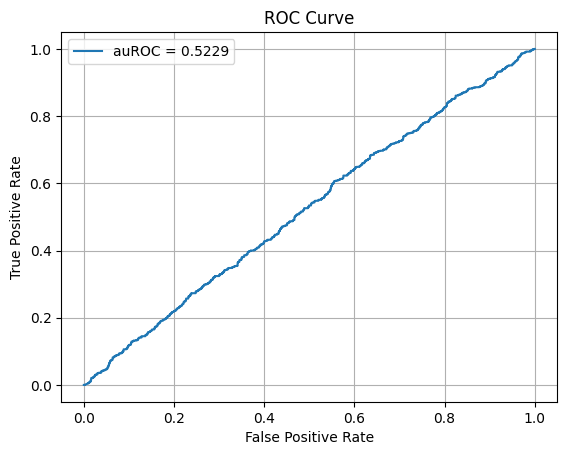

AUROC: 0.5229


In [24]:
# Compute and plot auroc 
# -----------------------------------
from src.analysis.dknn import compute_auroc
auroc, fpr, tpr, thresholds = compute_auroc(dknn_scores_id, dknn_scores_ood, plot=True)
print(f"AUROC: {auroc:.4f}")

:'(

# Brouillon

In [10]:
from src.inference.inference_utils import build_prompt, get_layer_output, compute_token_offsets

In [91]:
def extract_average_token_activations(
    selected_layer: torch.Tensor,
    attention_mask: torch.Tensor,
    device: torch.device,
    start_offset : int = 0,
    end_offset : int = 0
) -> torch.Tensor:
    """
    Extract the mean activation vector over a token span for each sequence in a batch.
    The span is defined by applying start_offset (from the first non-padding token)
    and end_offset (from the last non-padding token).

    Parameters
    ----------
    selected_layer : torch.Tensor
        Output tensor from the selected model layer (batch_size x seq_len x hidden_size).
    attention_mask : torch.Tensor
        Attention mask (batch_size x seq_len).
    device : torch.device
        Device for computation.
    start_offset : int
        Offset from first non-padding token (to skip e.g. [INST]).
    end_offset : int
        Offset from last non-padding token (to skip e.g. [/INST]).

    Returns
    -------
    torch.Tensor
        Averaged embeddings (batch_size x hidden_size)
    """
    batch_size, seq_len, _ = selected_layer.shape

    # Detect left padding if any sequence starts with padding
    is_left_padding = (attention_mask[:, 0] == 0).any()

    # Find the index of the first and the  last non-padding token for each sequence
    if is_left_padding:
        #--- For left padding, first non-padding token is at index: number of padding tokens
        first_indices = attention_mask.argmax(dim=1)
        #--- For left padding, last non-padding token is at the end: compute its index by flipping and offsetting from the end
        last_indices = (attention_mask.size(1) - 1) - attention_mask.flip(dims=[1]).argmax(dim=1)
    else:
        #--- For right padding, first non-padding token is always at index 0
        first_indices = torch.zeros(batch_size, dtype=torch.long, device=device)
        #--- For right padding, last non-padding token is at: (number of non-padding tokens) - 1
        last_indices = (attention_mask.sum(dim=1) - 1)

    first_indices = first_indices.to(device)
    last_indices = last_indices.to(device)

    # Apply offsets (e.g., skip <s> [INST] or [\INST])
    target_first_indices = first_indices + start_offset #-1
    target_last_indices = last_indices + end_offset #+1

    # Clamp indices to valid range
    target_first_indices = torch.clamp(target_first_indices, min=0, max=seq_len - 1)
    target_last_indices = torch.clamp(target_last_indices, min=0, max=seq_len - 1)

    # Compute mask for averaging
    #--- Create a tensor of positions: shape (1, seq_len), then expand to (batch_size, seq_len)
    positions = torch.arange(seq_len, device=device).unsqueeze(0).expand(batch_size, seq_len)
    #--- Build a boolean mask: True where the position is within [target_first_indices, target_last_indices] for each sequence
    mask = (positions >= target_first_indices.unsqueeze(1)) & (positions <= target_last_indices.unsqueeze(1))
    #--- Convert the boolean mask to float and add a singleton dimension for broadcasting with selected_layer
    mask = mask.float().unsqueeze(-1)  # (batch_size, seq_len, 1)

    # Apply mask and compute mean
    #--- Apply the mask to the activations: zero out tokens outside the target interval
    masked = selected_layer * mask
    #--- Count the number of selected tokens for each sequence (avoid division by zero with clamp)
    counts = mask.sum(dim=1).clamp(min=1e-6)
    #--- Compute the mean activation vector for each sequence over the selected interval
    avg = masked.sum(dim=1) / counts # (batch_size, hidden_size)

    # Optionally, return also the indices used
    indices = torch.stack([target_first_indices, target_last_indices], dim=1)

    return avg, indices

In [11]:
from transformers import PreTrainedTokenizer, PreTrainedModel, BatchEncoding
import torch
from datasets import  Dataset
from tqdm import tqdm
from typing import Dict, List, Any, Callable
import time

from src.evaluation.similarity_metrics import rouge_l_simScore, sentence_bert_simScore
from src.inference.inference_utils import extract_batch, generate_answers

def batch_extract_token_activations_with_generation(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 2,
    idx_start_sample: int = 0,
    max_samples: int = 2,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
    get_layer_output_fn: Callable = None,
    layer_idx: int = -1,  
    extract_token_activations_fn: Callable = None,
    **kwargs
):
    """
    Runs batched inference on a dataset using a decoder-only language model.
    For each batch, generates answers, computes semantic similarity scores, extracts token-level activations,
    and appends the results to a pickle file.

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    get_layer_output_fn : Callable
        Function to extract the output of a specific model layer.
    layer_idx : int
        Index of the transformer layer to extract activations from (default: -1 for last layer).
    extract_token_activations_fn : Callable
        Function to extract token activations from a model layer.
    **kwargs :
        Extra keyword arguments passed to extract_token_activations_fn.
    """
    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        batch_answers = []               # Generated answers
        batch_gt_answers = []            # Ground-truth answers
        batch_is_correct = []            # 0/1 labels indicating correctness
        batch_dataset_ids = []           # 'id' field from dataset
        batch_dataset_original_idx = []  # Original indices from dataset
        batch_rouge_scores = []          # Rouge-L scores
        batch_sbert_scores = []          # Sentence-Bert scores

        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]
        print(f"prompts: {prompts[0]},\n{prompts[1]}")
        answers = [s["answers"]["text"] for s in batch]
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)
        print(f"inputs:", inputs)
        selected_layer = get_layer_output_fn(model, inputs, layer_idx)
        selected_token_vecs, target_indices = extract_token_activations_fn(
                selected_layer, 
                inputs["attention_mask"], 
                device=selected_layer.device,
                **kwargs) 
        print("selected_token_vecs", selected_token_vecs)
        
        for k in range(len(prompts)):
            print("=========DECODING==========")
            print("target_indices[k]", target_indices[k])
            print(f"\nDecoding START target_indices[k]:-----{tokenizer.decode(inputs['input_ids'][k][target_indices[k][0]:target_indices[k][1]+1])}-----Decoding end\n")
            print(f"SELECTED TOKENS ---{tokenizer.decode(inputs['input_ids'][k][target_indices[k][0]])} and {tokenizer.decode(inputs['input_ids'][k][target_indices[k][1]])}---")
        
        output_ids = generate_answers(model, inputs, tokenizer)
        
        for j in range(len(prompts)):
            # --- Decode token IDs into text ---
            prompt_len = len(inputs["input_ids"][j]) # Length of prompt j
            generated_answer_ids = output_ids[j][prompt_len:] # Remove prompt prefix to isolate the generated answer
            generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()

            # --- Compute semantic similarity between model's answer and ground-truth ---    
            rouge_l_score = rouge_l_simScore(generated_answer, answers[j])
            if rouge_l_score >= 0.5:
                is_correct = True
                sbert_score = None
            else:
                sbert_score = sentence_bert_simScore(generated_answer, answers[j])
                is_correct = (sbert_score >= 0.4)

            # --- Store everything ---
            batch_dataset_ids.append(batch[j]['id'])
            batch_dataset_original_idx.append(batch[j]['original_index'])
            batch_answers.append(generated_answer)
            batch_gt_answers.append(answers[j])
            batch_is_correct.append(int(is_correct))
            batch_rouge_scores.append(rouge_l_score)
            batch_sbert_scores.append(sbert_score)

        # --- Save progress to pickle after each batch ---
        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "gen_answers": batch_answers,
            "ground_truths": batch_gt_answers,
            "activations": [selected_token_vecs[i].unsqueeze(0).cpu() for i in range(selected_token_vecs.size(0))],
            "is_correct": batch_is_correct,
            "sbert_scores": batch_sbert_scores,
            "rouge_scores": batch_rouge_scores
        }
        

In [11]:
text = build_prompt(id_fit_dataset[0]["context"], id_fit_dataset[0]["question"])
start_offset, end_offset = compute_token_offsets(
    text=text,
    tokenizer=tokenizer,
    start_phrase="<<SYS>>",
    end_phrase="Answer:\n",
    debug=True)

===== Input text =====
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST]

===== Decoded text between `start_offset` and `end_offset` =====
----START TEXT---<<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer

In [196]:
batch_extract_token_activations_with_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 0,
    max_samples= 2,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_impossible_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=extract_average_token_activations,
    start_offset = start_offset,
    end_offset = end_offset
)

  0%|          | 0/1 [00:00<?, ?it/s]

prompts: [INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST],
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
The term Carnival is traditionally used in 

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


In [13]:
from src.inference.inference_utils import (
    build_prompt, 
    compute_token_offsets, 
    get_layer_output
)
text = build_prompt(id_fit_dataset[0]["context"], id_fit_dataset[0]["question"])
start_offset, end_offset = compute_token_offsets(
    text=text,
    tokenizer=tokenizer,
    start_phrase="\nContext:",
    end_phrase="Answer:\n",
    debug=True)


===== Input text =====
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST]

===== Decoded text between `start_offset` and `end_offset` =====
----START TEXT---
Context:
Under a front page headline "The Truth", the paper printed allegations provided t

In [23]:
batch_extract_token_activations_with_generation(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 0,
    max_samples= 2,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_impossible_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=extract_average_token_activations,
    start_offset = start_offset,
    end_offset = end_offset
)

  0%|          | 0/1 [00:00<?, ?it/s]

prompts: [INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Under a front page headline "The Truth", the paper printed allegations provided to them that some fans picked the pockets of crushed victims, that others urinated on members of the emergency services as they tried to help and that some even assaulted a police constable "whilst he was administering the kiss of life to a patient." Despite the headline, written by Kelvin MacKenzie, the story was based on allegations either by unnamed and unattributable sources, or hearsay accounts of what named individuals had said – a fact made clear to MacKenzie by Harry Arnold, the reporter who wrote the story.

Question:
What was the story based on?

Answer:
[/INST],
[INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
The term Carnival is traditionally used in 

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


In [45]:
from transformers import PreTrainedTokenizer, PreTrainedModel, BatchEncoding
import torch
from datasets import  Dataset
from tqdm import tqdm
from typing import Dict, List, Any, Callable, Tuple
import time
from src.inference.inference_utils import generate_answers, extract_batch

def batch_extract_answer_token_activations(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 4,
    idx_start_sample: int = 0,
    max_samples: int = 1000,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
    get_layer_output_fn: Callable = None,
    layer_idx: int = -1,  
    extract_token_activations_fn: Callable = None, 
    include_prompt: bool = True,
    **kwargs
):
    """
    Runs batched inference on a dataset using a decoder-only language model.
    For each batch, generates answers, extracts token-level activations for the generated answer,
    and appends the results to a pickle file.

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    get_layer_output_fn : Callable
        Function to extract the output of a specific model layer. 
    layer_idx : int
        Index of the transformer layer to extract activations from (default: -1 for last layer).
    extract_token_activations_fn : Callable
        Function to extract token activations from a model layer (default is average).
    include_prompt : bool
        Whether to include the prompt in the embedding extraction.
        *Note:* Tokenization will always include the prompt.  
    **kwargs :
        Extra keyword arguments passed to extract_token_activations_fn, including start_offset.
    """
    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        batch_answers = []               # Generated answers
        batch_generated_embeddings = []  # Embeddings of generated answers
        batch_dataset_ids = []           # 'id' field from dataset
        batch_dataset_original_idx = []  # Original indices from dataset

        # Extract a batch from the dataset
        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]
        
        # Tokenize the prompt 
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)

        # Generate the answers for the batch
        output_ids = generate_answers(model, inputs, tokenizer)
        
        for j in range(len(prompts)):
            print(f"***************** j={j} *****************")
            # --- Decode token IDs into text ---
            prompt_len = len(inputs["input_ids"][j])  # Length of the prompt for example j
            generated_answer_ids = output_ids[j][prompt_len:]  # Remove prompt part
            generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()
            print("prompt_len: ", prompt_len)
            
            # Create the full sequence: prompt + generated answer
            full_input_sequence = tokenizer.decode(inputs["input_ids"][j], skip_special_tokens=True) + generated_answer
            print("full_input_sequence", full_input_sequence)
            
            # --- Tokenize the full sequence (prompt + generated answer) for activation extraction ---
            # We cannot directly use `output_ids` and need to retokenize since we need attention_mask for get_layer_output_fn
            full_inputs = tokenizer(full_input_sequence, padding=True, truncation=True, return_tensors="pt").to(model.device)
            print("full_inputs", full_inputs)

            # --- Extract token embeddings for the full sequence ---
            selected_layer = get_layer_output_fn(model, full_inputs, layer_idx)

            # --- Start offset : if include_prompt is True, we start after the prompt ---
            if include_prompt:
                start_offset = prompt_len  # Start after the prompt if we include the prompt
            else:
                start_offset = kwargs.get("start_offset", 0)  # Get start_offset from kwargs if no prompt included
            
            # Call the specified activation extraction function
            selected_token_vecs, target_indices  = extract_token_activations_fn(
                selected_layer, 
                full_inputs["attention_mask"], 
                device=selected_layer.device,
                start_offset=start_offset,  # Pass start_offset (calculated above)
                **kwargs  # Pass other kwargs as needed (e.g., end_offset, etc.)
            )

            print("=========DECODING==========")
            print("target_indices", target_indices)
            print(f"\nDecoding START target_indices:-----{tokenizer.decode(full_inputs['input_ids'][0][target_indices[0][0]:target_indices[0][1]+1].tolist())}-----Decoding end\n")

            print("=========END DECODING==========")

            # --- Store everything ---
            batch_dataset_ids.append(batch[j]['id'])
            batch_dataset_original_idx.append(batch[j]['original_index'])
            batch_answers.append(generated_answer)
            batch_generated_embeddings.append(selected_token_vecs.cpu())

        # --- Save progress to pickle after each batch ---
        '''
        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "gen_answers": batch_answers,
            "activations": batch_generated_embeddings
        }
        '''
        #append_to_pickle(output_path, batch_results)


In [47]:
batch_extract_answer_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 2,
    max_samples= 2,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=extract_average_token_activations,
    include_prompt = True,
    #start_offset = 0,
    end_offset = 0
)

  0%|          | 0/1 [00:00<?, ?it/s]

***************** j=0 *****************
prompt_len:  341
full_input_sequence [INST] <<SYS>>
Just give the answer, without a complete sentence. Reply with 'Impossible to answer' if answer not in context.
<<SYS>>

Context:
Madonna gave another provocative performance later that year at the 2003 MTV Video Music Awards, while singing "Hollywood" with Britney Spears, Christina Aguilera, and Missy Elliott. Madonna sparked controversy for kissing Spears and Aguilera suggestively during the performance. In October 2003, Madonna provided guest vocals on Spears' single "Me Against the Music". It was followed with the release of Remixed & Revisited. The EP contained remixed versions of songs from American Life and included "Your Honesty", a previously unreleased track from the Bedtime Stories recording sessions. Madonna also signed a contract with Callaway Arts & Entertainment to be the author of five children's books. The first of these books, titled The English Roses, was published in September

100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

=========DECODING==========
target_indices tensor([[198, 198]], device='cuda:0')

Decoding START target_indices:-----acy-----Decoding end

=========END DECODING==========


In [ ]:
selected_token_vecs, target_indices = extract_token_activations_fn(
                selected_layer, 
                inputs["attention_mask"], 
                device=selected_layer.device,
                **kwargs) 
        print("selected_token_vecs", selected_token_vecs)
        
        for k in range(len(prompts)):
            print("=========DECODING==========")
            print("target_indices[k]", target_indices[k])
            print(f"\nDecoding START target_indices[k]:-----{tokenizer.decode(inputs['input_ids'][k][target_indices[k][0]:target_indices[k][1]+1])}-----Decoding end\n")
            print(f"SELECTED TOKENS ---{tokenizer.decode(inputs['input_ids'][k][target_indices[k][0]])} and {tokenizer.decode(inputs['input_ids'][k][target_indices[k][1]])}---")
        

In [59]:
batch_extract_answer_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 2,
    max_samples= 2,
    output_path = "outputs/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=extract_average_token_activations,
    include_prompt = True,
    #start_offset = 0,
    end_offset = 0
)

  0%|          | 0/1 [00:00<?, ?it/s]

***************** j=0 *****************
generated_answer The English Roses
prompt_len:  341
***************** j=1 *****************
generated_answer Literacy
prompt_len:  341
**********************************
full_input_sequence ['[INST] <<SYS>>\nJust give the answer, without a complete sentence. Reply with \'Impossible to answer\' if answer not in context.\n<<SYS>>\n\nContext:\nMadonna gave another provocative performance later that year at the 2003 MTV Video Music Awards, while singing "Hollywood" with Britney Spears, Christina Aguilera, and Missy Elliott. Madonna sparked controversy for kissing Spears and Aguilera suggestively during the performance. In October 2003, Madonna provided guest vocals on Spears\' single "Me Against the Music". It was followed with the release of Remixed & Revisited. The EP contained remixed versions of songs from American Life and included "Your Honesty", a previously unreleased track from the Bedtime Stories recording sessions. Madonna also signed a co

100%|██████████| 1/1 [00:03<00:00,  3.76s/it]

=========DECODING==========
target_indices[k] tensor([341, 344], device='cuda:0')

Decoding START target_indices[k]:-----The English Roses-----Decoding end

=========END DECODING==========
=========DECODING==========
target_indices[k] tensor([344, 344], device='cuda:0')

Decoding START target_indices[k]:-----acy-----Decoding end

=========END DECODING==========


In [15]:
from transformers import PreTrainedTokenizer, PreTrainedModel, BatchEncoding
import torch
from datasets import  Dataset
from tqdm import tqdm
from typing import Dict, List, Any, Callable, Tuple
import time
from src.inference.inference_utils import (
    build_prompt,
    get_layer_output,
    generate_answers, 
    extract_batch, 
    extract_last_token_activations,
    extract_average_token_activations,
    extract_max_token_activations
)
from src.data_reader.pickle_io import append_to_pickle


def batch_extract_answer_token_activations(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    dataset: Dataset,
    batch_size: int = 4,
    idx_start_sample: int = 0,
    max_samples: int = 1000,
    save_to_pkl: bool = False,
    output_path: str = "outputs/all_batch_results.pkl",
    build_prompt_fn: Callable[[str, str], str] = None,
    get_layer_output_fn: Callable = None,
    layer_idx: int = -1,  
    extract_token_activations_fn: Callable = None, 
    include_prompt: bool = True,
    **kwargs
):
    """
    Runs batched inference on a dataset using a decoder-only language model.
    For each batch, generates answers, extracts token-level activations for the generated answer,
    and appends the results to a pickle file.

    Parameters
    ----------
    model : PreTrainedModel
        The causal language model to evaluate (e.g., LLaMA).
    tokenizer : PreTrainedTokenizer
        The corresponding tokenizer.
    dataset : Dataset
        The input dataset.
    batch_size : int
        Number of samples per batch.
    idx_start_sample : int
        Index of the first sample to process from the dataset.
    max_samples : int
        Total number of examples to process from the dataset, starting from idx_start_sample. 
    save_to_pkl : bool
        If True, activations are appended to the pickle file at output_path.
        If False, the function returns a list of activations.
    output_path : str
        Path to the pickle file for saving intermediate results.
    build_prompt_fn : Callable
        Function to build a prompt from context and question.
    get_layer_output_fn : Callable
        Function to extract the output of a specific model layer. 
    layer_idx : int
        Index of the transformer layer to extract activations from (default: -1 for last layer).
    extract_token_activations_fn : Callable
        Function to extract token activations from a model layer (default is average).
    include_prompt : bool
        Whether to include the prompt in the embedding extraction.
        *Note:* Tokenization will always include the prompt.  
    **kwargs :
        Extra keyword arguments passed to extract_token_activations_fn, including start_offset.
    """    
    batch_activations = []  # Chosen token activation vectors

    for i in tqdm(range(idx_start_sample, idx_start_sample + max_samples, batch_size)):
        batch_answers = []   # Generated answers
 
        # Extract a batch from the dataset
        batch = extract_batch(dataset, i, batch_size)
        prompts = [build_prompt_fn(s["context"], s["question"]) for s in batch]

        # Tokenize the prompt 
        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(model.device)
        
        # Compute the number of non-padding tokens in each prompt (true prompt length)
        prompt_non_pad_len = inputs["attention_mask"].sum(dim=1).tolist()  # Shape (batch_size,)
        print("prompt_lens", prompt_non_pad_len)

        # Generate the answers for the batch
        output_ids = generate_answers(model, inputs, tokenizer)

        # Build full sequences (prompt + generated answer) for each sample in the batch
        full_sequences = []
        for j in range(len(prompts)):
            # --- Total length of the tokenized prompt, padding included ---
            prompt_len = len(inputs["input_ids"][j])  # Length of the prompt for example j
            # --- Decode token IDs into text ---
            generated_answer_ids = output_ids[j][prompt_len:]  # Remove prompt part
            generated_answer = tokenizer.decode(generated_answer_ids, skip_special_tokens=True).strip()
            # --- Decode the prompt tokens to text ---
            prompt_text = tokenizer.decode(inputs["input_ids"][j], skip_special_tokens=True)
            # --- Combine prompt and answer for full sequence ---
            full_sequences.append(prompt_text + generated_answer)
            # --- Store generated answers ---
            batch_answers.append(generated_answer)
            print("generated_answer:",generated_answer )

        # Tokenize the full sequences (prompt + answer) again, with padding and truncation
        # We need to retokenize and cannot directly use `output_ids` since we need attention_mask for get_layer_output_fn
        full_inputs = tokenizer(full_sequences, padding=True, truncation=True, return_tensors="pt").to(model.device)

        # Extract activations from the specified model layer for all sequences in the batch
        selected_layer = get_layer_output_fn(model, full_inputs, layer_idx)

        # Compute the start offsets for activation extraction
        if include_prompt:
            # --- If include_prompt is True, use the value from kwargs (or zeros if not provided) ---
            start_offsets = kwargs.get("start_offset", torch.zeros(len(prompts), device=selected_layer.device)) # Shape (batch_size,) 
        else:
            # --- If include_prompt is False, use the true prompt length (non-padding tokens) ---
            start_offsets = torch.tensor(prompt_non_pad_len, device=selected_layer.device)  # Shape (batch_size,) 

        # Remove start_offset from kwargs to avoid passing it twice to the extraction function
        kwargs.pop("start_offset", None)

        # Call the specified activation extraction function
        selected_token_vecs, target_indices = extract_token_activations_fn(
            selected_layer,
            full_inputs["attention_mask"],
            device=selected_layer.device,
            start_offset=start_offsets,  # Shape (batch_size,) 
            **kwargs
        )
        
        # 9. (Optional) Decode for verification 
        if False:
            for k in range(len(prompts)):
                print("=========DECODING==========")
                print("target_indices[k]", target_indices[k])
                print(f"\nDecoding START target_indices[k]:-----{tokenizer.decode(full_inputs['input_ids'][k][int(target_indices[k][0]):int(target_indices[k][1])+1])}-----Decoding end\n")
                print("=========END DECODING==========")

        # --- Store everything ---
        batch_dataset_ids = [s['id'] for s in batch]  # 'id' field from dataset
        batch_dataset_original_idx = [s['original_index'] for s in batch] # Original indices from dataset
        activations = [selected_token_vecs[j].unsqueeze(0).cpu() for j in range(selected_token_vecs.size(0))] # Embeddings of generated answers

       
        # --- Save progress to pickle after each batch ---
        batch_results = {
            "id": batch_dataset_ids,
            "original_indices": batch_dataset_original_idx,
            "gen_answers": batch_answers,
            "activations": activations
        }

        if save_to_pkl:
            append_to_pickle(output_path, batch_results)
        else:
            batch_activations.extend(activations)
        
    if not save_to_pkl:
        return batch_activations

In [17]:
from src.inference.inference_utils import batch_extract_answer_token_activations
batch_extract_answer_token_activations(
    model=model,
    tokenizer=tokenizer,
    dataset=id_fit_dataset,
    batch_size=2,
    idx_start_sample= 5,
    max_samples=10,
    save_to_pkl = False, 
    output_path = "../raw/TEST/all_batch_results.pkl",
    build_prompt_fn=build_prompt,
    get_layer_output_fn=get_layer_output,
    layer_idx = -1,  
    extract_token_activations_fn=extract_max_token_activations,
    include_prompt = False,
    start_offset = 40,
    end_offset = 0
)

100%|██████████| 5/5 [00:06<00:00,  1.33s/it]
